In [53]:
import os.path as path
from pyspark.sql import SparkSession
from pyspark.sql import column
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

from functools import reduce

In [54]:
def init_spark():
  return SparkSession \
        .builder \
        .appName("Spark") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "8g") \
        .getOrCreate()

spark = init_spark()


In [55]:
# df = spark.read.option("delimiter", "\t").option("header", True).csv("archive_imdb/action.csv")

genres_to_keep = ["action", "adventure", "horror", "crime", "romance"]


In [56]:
dfs=[]
  # distFile=spark.sparkContext.textFile(filename).map(parse_csv)
for gen in genres_to_keep:
    # final_df_read_act = spark.sparkContext.textFile("archive_imdb/"+gen+".csv").map(parse_csv).withColumn("genre",lit(gen))
    final_df_read_act=spark.read.option("header", "true").option("multiline", "true").csv("archive_imdb/"+gen+".csv").withColumn("genre",lit(gen)).limit(10000)
    dfs.append(final_df_read_act)

def unionAll(dfs):
    return reduce(DataFrame.unionAll, dfs)

# Merge DataFrames
merged_df = unionAll(dfs)


In [57]:
merged_df.head()


Row(movie_id='tt9114286', movie_name='Black Panther: Wakanda Forever', year='2022', certificate='PG-13', runtime='161 min', genre='action', rating='6.9', description="The people of Wakanda fight to protect their home from intervening world powers as they mourn the death of King T'Challa.", director='Ryan Coogler', director_id='/name/nm3363032/', star="Letitia Wright, \nLupita Nyong'o, \nDanai Gurira, \nWinston Duke", star_id='/name/nm4004793/,/name/nm2143282/,/name/nm1775091/,/name/nm6328300/', votes='204835.0', gross(in $)=None)

In [58]:
merged_df.count()
df=merged_df

In [59]:
df=df.drop("year","certificate","runtime","rating","votes","gross(in $)","star_id","director_id")

In [60]:
df.columns

['movie_id', 'movie_name', 'genre', 'description', 'director', 'star']

In [61]:
def show_null_values_distribution(df):
    null_value_list = list()
    for col_ in df.columns:
        null_value_list.append(df.filter(df[col_]=="\\N").count())                     
    plt.rcParams["figure.figsize"] = (10,6)
    columns = [col_ for col_ in df.columns]
    
    plt.figure(figsize=(10, 6))
    plt.bar(columns, null_value_list, color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Number of Null Values')
    plt.ylim(0, df.count())
    plt.title('Distribution of Null Values in Columns')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [62]:
def drop_duplicates(df):
    print(df.count())
    train_df=df.dropDuplicates()
    print(df.count())

In [63]:

df = df.withColumn("actors", split(df["star"], ", \n"))

df = df.withColumn("actor1", df.actors[0])
df = df.withColumn("actor2", df.actors[1])
df = df.withColumn("actor3", df.actors[2])
df=df.drop("actors","star")

 


In [64]:
df.head()

Row(movie_id='tt9114286', movie_name='Black Panther: Wakanda Forever', genre='action', description="The people of Wakanda fight to protect their home from intervening world powers as they mourn the death of King T'Challa.", director='Ryan Coogler', actor1='Letitia Wright', actor2="Lupita Nyong'o", actor3='Danai Gurira')

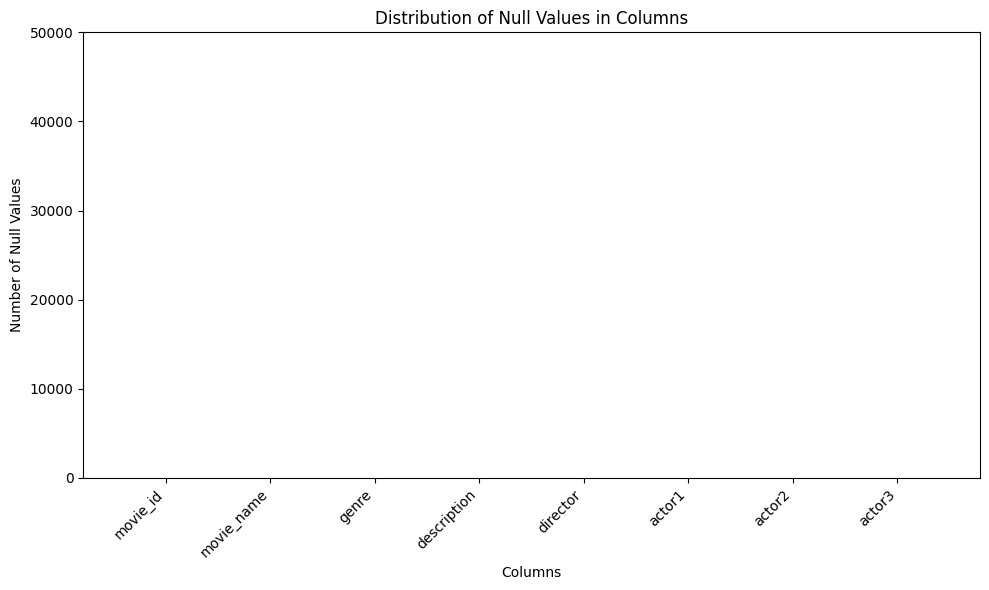

In [65]:
show_null_values_distribution(df)

In [66]:
drop_duplicates(df)

50000
50000


In [67]:
def print_class_distribution(df):
    # Group the DataFrame by the "genre" column and count the occurrences of each genre
    genre_counts = df.groupBy("genre").count()
    
    # Show the genre counts
    genre_counts.show()

In [68]:
# df=df

In [69]:
print_class_distribution(df)

+---------+-----+
|    genre|count|
+---------+-----+
|   action|10000|
|adventure|10000|
|   horror|10000|
|    crime|10000|
|  romance|10000|
+---------+-----+



In [70]:
df

DataFrame[movie_id: string, movie_name: string, genre: string, description: string, director: string, actor1: string, actor2: string, actor3: string]

In [71]:
# df=df.drop("year","certificate","runtime","rating","gross(in $)")

In [72]:
df.columns

['movie_id',
 'movie_name',
 'genre',
 'description',
 'director',
 'actor1',
 'actor2',
 'actor3']

In [73]:
df.write.option("header", "true").csv("final_dataset_all_imdb.csv")